In [66]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV


In [1]:
verbose = True # outputs messages to stdout and stderr for debug purposes

debug_mode = 0

max_time = 90 

max_cycle = 1#100

import datetime
zipme = True # use this flag to enable zipping of your code submission
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
submission_filename = '../automl_sample_submission_' + the_date

default_input_dir = "../data/hackathon/" #"/home/ubuntu/Data"
default_output_dir = "res"

version = 2.7

# General purpose functions
import os
from sys import argv, path
import numpy as np
import time
overall_start = time.time()
from sklearn.ensemble import RandomForestClassifier as RForestClass

# Our directories
# Note: On codalab, there is an extra sub-directory called "program"
running_on_codalab = False
run_dir = os.path.abspath(".")
codalab_run_dir = os.path.join(run_dir, "program")
if os.path.isdir(codalab_run_dir): 
    run_dir=codalab_run_dir
    running_on_codalab = True
    print "Running on Codalab!"
lib_dir = os.path.join(run_dir, "lib")
res_dir = os.path.join(run_dir, "res")

# Our libraries  
path.append (run_dir)
path.append (lib_dir)
import data_io                       # general purpose input/output functions
from data_io import vprint           # print only in verbose mode
from data_manager import DataManager # load/save data and get info about them

if debug_mode >= 4 or running_on_codalab: # Show library version and directory structure
    data_io.show_version()
    data_io.show_dir(run_dir)

execution_success = True

input_dir = default_input_dir
output_dir = default_output_dir

# Move old results and create a new output directory 
if not(running_on_codalab):
    data_io.mvdir(output_dir, '../'+output_dir+'_'+the_date) 
data_io.mkdir(output_dir) 

#### INVENTORY DATA (and sort dataset names alphabetically)
datanames = data_io.inventory_data(input_dir)

#### DEBUG MODE: Show dataset list and STOP
if debug_mode>=3:
    data_io.show_io(input_dir, output_dir)
    print('\n****** Sample code version ' + str(version) + ' ******\n\n' + '========== DATASETS ==========\n')        	
    data_io.write_list(datanames)      
    datanames = [] # Do not proceed with learning and testing

In [2]:
if len(datanames)>0:
    vprint( verbose,  "************************************************************************")
    vprint( verbose,  "****** Attempting to copy files (from res/) for RESULT submission ******")
    vprint( verbose,  "************************************************************************")
    OK = data_io.copy_results(datanames, res_dir, output_dir, verbose) # DO NOT REMOVE!
    if OK: 
        vprint( verbose,  "[+] Success")
        datanames = [] # Do not proceed with learning and testing
    else:
        vprint( verbose, "======== Some missing results on current datasets!")
        vprint( verbose, "======== Proceeding to train/test:\n")
        
    overall_time_budget = 0
    for basename in datanames: # Loop over datasets
        if basename != "madeline":
            continue
        else:
            vprint( verbose,  "************************************************")
            vprint( verbose,  "******** Processing dataset " + basename.capitalize() + " ********")
            vprint( verbose,  "************************************************")

            # ======== Learning on a time budget:
            # Keep track of time not to exceed your time budget. Time spent to inventory data neglected.
            start = time.time()
            
            

            # ======== Creating a data object with data, informations about it
            vprint( verbose,  "======== Reading and converting data ==========")
            D = DataManager(basename, input_dir, replace_missing=True, filter_features=True, verbose=verbose)
            print D
            
            # ======== Keeping track of time
            if debug_mode<1:
                time_budget = D.info['time_budget']        # <== HERE IS THE TIME BUDGET!
            else:
                time_budget = max_time

            ########## PETERSBURG HACKATHON: 2 min per dataset
            time_budget = 2 * 60

            overall_time_budget = overall_time_budget + time_budget
            time_spent = time.time() - start
            vprint( verbose,  "[+] Remaining time after reading data %5.2f sec" % (time_budget-time_spent))
            if time_spent >= time_budget:
                vprint( verbose,  "[-] Sorry, time budget exceeded, skipping this task")
                execution_success = False
                continue

                # ========= Iterating over learning cycles and keeping track of time
            time_spent = time.time() - start
            vprint( verbose,  "[+] Remaining time after building model %5.2f sec" % (time_budget-time_spent))        
            if time_spent >= time_budget:
                vprint( verbose,  "[-] Sorry, time budget exceeded, skipping this task")
                execution_success = False
                continue

            time_budget = time_budget - time_spent # Remove time spent so far
            start = time.time()              # Reset the counter
            time_spent = 0                   # Initialize time spent learning
            time_spent_last = 0                   # Initialize time spent learning
            cycle = 0

            while  cycle <= 1: #max_cycle:
                begin = time.time()
                vprint( verbose,  "=========== " + basename.capitalize() +" Training cycle " + str(cycle) +" ================") 
                n_estimators = 10
                if cycle==1:
                    n_estimators = int((np.floor(time_budget / time_spent_last) - 1 ) * 5) # * 5 == aim to use 5/10 of the time budget
                    if n_estimators <= 0:
                        break
                vprint( verbose,  "[+] Number of estimators: %d" % (n_estimators))   

                K = D.info['target_num']
                sparse = False
                if D.info['is_sparse'] == 1:
                    sparse = True
            
                M = RForestClass(n_estimators, random_state=1).fit(D.data['X_train'], D.data['Y_train'])
                Y_valid = M.predict_proba(D.data['X_valid'])[:, 1]
                Y_test =  M.predict_proba(D.data['X_test'])[:, 1]


                vprint( verbose,  "[+] Prediction success, time spent so far %5.2f sec" % (time.time() - start))
                # Write results
                filename_valid = basename + '_valid_' + str(cycle).zfill(3) + '.predict'
                data_io.write(os.path.join(output_dir,filename_valid), Y_valid)
                filename_test = basename + '_test_' + str(cycle).zfill(3) + '.predict'
                data_io.write(os.path.join(output_dir,filename_test), Y_test)
                vprint( verbose,  "[+] Results saved, time spent so far %5.2f sec" % (time.time() - start))         
                time_spent = time.time() - start 
                vprint( verbose,  "[+] End cycle, remaining time %5.2f sec" % (time_budget-time_spent))
                cycle += 1
                time_spent_last = time.time() - begin
                time_budget = time_budget - time_spent_last # Remove time spent so far
            continue
            
        
        
        
        
        
        
#         vprint( verbose,  "************************************************")
#         vprint( verbose,  "******** Processing dataset " + basename.capitalize() + " ********")
#         vprint( verbose,  "************************************************")

        # ======== Learning on a time budget:
        # Keep track of time not to exceed your time budget. Time spent to inventory data neglected.
        start = time.time()

        # ======== Creating a data object with data, informations about it
        vprint( verbose,  "======== Reading and converting data ==========")
        D = DataManager(basename, input_dir, replace_missing=True, filter_features=True, verbose=verbose)
        print D

        # ======== Keeping track of time
        if debug_mode<1:
            time_budget = D.info['time_budget']        # <== HERE IS THE TIME BUDGET!
        else:
            time_budget = max_time

        ########## PETERSBURG HACKATHON: 2 min per dataset
        time_budget = 2 * 60

        overall_time_budget = overall_time_budget + time_budget
        time_spent = time.time() - start
        vprint( verbose,  "[+] Remaining time after reading data %5.2f sec" % (time_budget-time_spent))
        if time_spent >= time_budget:
            vprint( verbose,  "[-] Sorry, time budget exceeded, skipping this task")
            execution_success = False
            continue

        # ========= Creating a model, knowing its assigned task from D.info['task'].
        # The model can also select its hyper-parameters based on other elements of info.  
        # vprint( verbose,  "======== Creating model ==========")
        # M = MyAutoML(D.info, verbose, debug_mode)
        # print M

        # ========= Iterating over learning cycles and keeping track of time
        time_spent = time.time() - start
        vprint( verbose,  "[+] Remaining time after building model %5.2f sec" % (time_budget-time_spent))        
        if time_spent >= time_budget:
            vprint( verbose,  "[-] Sorry, time budget exceeded, skipping this task")
            execution_success = False
            continue

        time_budget = time_budget - time_spent # Remove time spent so far
        start = time.time()              # Reset the counter
        time_spent = 0                   # Initialize time spent learning
        time_spent_last = 0                   # Initialize time spent learning
        cycle = 0

        while  cycle <= 1: #max_cycle:
            begin = time.time()
            vprint( verbose,  "=========== " + basename.capitalize() +" Training cycle " + str(cycle) +" ================") 
            n_estimators = 10
            if cycle==1:
                n_estimators = int((np.floor(time_budget / time_spent_last) - 1 ) * 5) # * 5 == aim to use 5/10 of the time budget
                if n_estimators <= 0:
                    break
            vprint( verbose,  "[+] Number of estimators: %d" % (n_estimators))   

            K = D.info['target_num']
            sparse = False
            if D.info['is_sparse'] == 1:
                sparse = True


            task = D.info['task']

            if task == 'binary.classification' or task == 'multiclass.classification':
                if sparse:
                    M = BaggingClassifier(base_estimator=BernoulliNB(), n_estimators=n_estimators/10).fit(D.data['X_train'], D.data['Y_train'])
                else:
                    M = RForestClass(n_estimators, random_state=1).fit(D.data['X_train'], D.data['Y_train'])
            elif task == 'multilabel.classification':
                if sparse:
                    Ms = [BaggingClassifier(base_estimator=BernoulliNB(), n_estimators=n_estimators/10).fit(D.data['X_train'], D.data['Y_train'][:, i]) for i in range(K)]
                else:
                    Ms = [RForestClass(n_estimators, random_state=1).fit(D.data['X_train'], D.data['Y_train'][:, i]) for i in range(K)]
            elif task == 'regression':  
                if sparse:
                    M = BaggingRegressor(base_estimator=BernoulliNB(), n_estimators=n_estimators/10).fit(D.data['X_train'], D.data['Y_train'])
                else:            
                    M = RForestRegress(n_estimators, random_state=n_estimators).fit(D.data['X_train'], D.data['Y_train'])
            else:
                vprint( verbose,  "[-] task not recognised")
                break         
            vprint( verbose,  "[+] Fitting success, time spent so far %5.2f sec" % (time.time() - start))


            # Make predictions
            if task == 'binary.classification':
                Y_valid = M.predict_proba(D.data['X_valid'])[:, 1]
                Y_test =  M.predict_proba(D.data['X_test'])[:, 1]

            vprint( verbose,  "[+] Prediction success, time spent so far %5.2f sec" % (time.time() - start))
            # Write results
            filename_valid = basename + '_valid_' + str(cycle).zfill(3) + '.predict'
            data_io.write(os.path.join(output_dir,filename_valid), Y_valid)
            filename_test = basename + '_test_' + str(cycle).zfill(3) + '.predict'
            data_io.write(os.path.join(output_dir,filename_test), Y_test)
            vprint( verbose,  "[+] Results saved, time spent so far %5.2f sec" % (time.time() - start))         
            time_spent = time.time() - start 
            vprint( verbose,  "[+] End cycle, remaining time %5.2f sec" % (time_budget-time_spent))
            cycle += 1
            time_spent_last = time.time() - begin
            time_budget = time_budget - time_spent_last # Remove time spent so far

************************************************************************
****** Attempting to copy files (from res/) for RESULT submission ******
************************************************************************
[-] Missing 'test' result files for christine
======== Some missing results on current datasets!
======== Proceeding to train/test:

************************************************
******** Processing dataset Madeline ********
************************************************
======== Reading and converting data ==========
Info file found : /home/alex/Documents/Development/MLSchool2015/data/hackathon/madeline/madeline_public.info
========= Reading ../data/hackathon/madeline/madeline_feat.type
[+] Success in  0.00 sec
========= Reading ../data/hackathon/madeline/madeline_train.data
[+] Success in  0.16 sec
========= Reading ../data/hackathon/madeline/madeline_train.solution
[+] Success in  0.00 sec
========= Reading ../data/hackathon/madeline/madeline_valid.data
[+] Succe

In [119]:
def detect_correlation(X, th=0.95):
    df = pd.DataFrame(X)
    cor_mat = df.corr()
    m = cor_mat.shape[0]
    flat_cor_mat = cor_mat.values.reshape(1, cor_mat.shape[0]*cor_mat.shape[1])
    correlated_idx = np.nonzero(flat_cor_mat > th)[1]
    mat_idx = [(i % m, i / m) for i in correlated_idx if i % m != i / m]
    second_first_idx = {i[1]: i[0] for i in mat_idx}
    reduced_mat_idx = []
    for t in mat_idx:
        if ((t[1], t[0]) not in reduced_mat_idx):
            reduced_mat_idx.append(t)
    first_idx = set([t[0] for t in reduced_mat_idx])
    second_idx = set([t[1] for t in reduced_mat_idx])
    result_idx = first_idx - second_idx
    m = X.shape[1]
    target_idx = set(range(m)) - result_idx
    return X[:, list(target_idx)]

In [120]:
X_train = D.data["X_train"]
y_train = D.data["Y_train"]
X_test = D.data["X_test"]
X_valid = D.data["X_valid"]
print X_train.shape
X_train_red = detect_correlation(X_train)
print X_train_red.shape

(3140, 259)
(3140, 252)


<matplotlib.colorbar.Colorbar instance at 0x7f6bd80b9488>

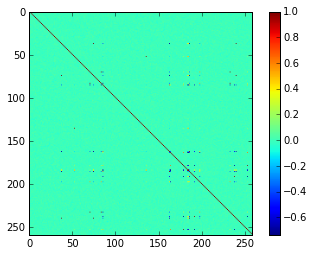

In [121]:
df = pd.DataFrame(X_train)
cor_mat = df.corr()
plt.imshow(cor_mat)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f6bda3b5440>

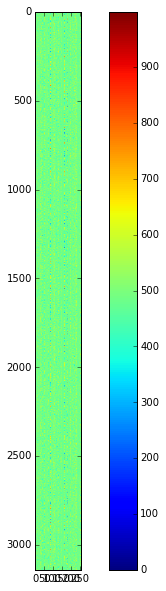

In [52]:
plt.figure(figsize=(10,10))
plt.imshow(X_train)
plt.colorbar()

In [122]:
features_train, features_test, target_train, target_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0)

gb = GradientBoostingClassifier()
gb_params = {
    'learning_rate': [0.05, 0.1, 0.5],
    'max_features': [0.5, 1],
    'max_depth': [3, 4, 5],
}
gs = GridSearchCV(gb, gb_params, cv=5, scoring='accuracy', n_jobs=1)
gs.fit(features_train, target_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'max_features': [0.5, 1], 'learning_rate': [0.05, 0.1, 0.5], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=0)

In [123]:
print gs.best_params_
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)

{'max_features': 0.5, 'learning_rate': 0.05, 'max_depth': 5}


[mean: 0.82325, std: 0.01531, params: {'max_features': 0.5, 'learning_rate': 0.05, 'max_depth': 5},
 mean: 0.81330, std: 0.01676, params: {'max_features': 0.5, 'learning_rate': 0.1, 'max_depth': 5},
 mean: 0.78185, std: 0.01270, params: {'max_features': 0.5, 'learning_rate': 0.05, 'max_depth': 4},
 mean: 0.77468, std: 0.01470, params: {'max_features': 0.5, 'learning_rate': 0.5, 'max_depth': 5},
 mean: 0.77389, std: 0.00991, params: {'max_features': 0.5, 'learning_rate': 0.1, 'max_depth': 4},
 mean: 0.74801, std: 0.02426, params: {'max_features': 0.5, 'learning_rate': 0.1, 'max_depth': 3},
 mean: 0.74602, std: 0.02045, params: {'max_features': 0.5, 'learning_rate': 0.05, 'max_depth': 3},
 mean: 0.73885, std: 0.01160, params: {'max_features': 0.5, 'learning_rate': 0.5, 'max_depth': 4},
 mean: 0.71537, std: 0.01601, params: {'max_features': 0.5, 'learning_rate': 0.5, 'max_depth': 3},
 mean: 0.59833, std: 0.02059, params: {'max_features': 1, 'learning_rate': 0.05, 'max_depth': 5},
 mean: 0

In [124]:
best_gb = GradientBoostingClassifier(learning_rate=0.05, max_depth=5, max_features=0.5)
best_gb.fit(features_train, target_train)
print best_gb.score(features_test, target_test)

0.84076433121


In [83]:
rf = RForestClass(n_jobs=3)
rf_params = {
    "criterion": ["entropy", "gini"],
    "max_features": [0.5, 1, "log2", "sqrt"],
    "max_depth": [3, 5, 7, 10],
    "n_estimators": [10, 50, 100, 1000],
}
gs = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=3)
gs.fit(features_train, target_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=3,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=3,
       param_grid={'max_features': [0.5, 1, 'log2', 'sqrt'], 'n_estimators': [10, 50, 100, 1000], 'criterion': ['entropy', 'gini'], 'max_depth': [3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=0)

In [84]:
print gs.best_params_
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)

{'max_features': 0.5, 'n_estimators': 100, 'criterion': 'entropy', 'max_depth': 10}


[mean: 0.84236, std: 0.01434, params: {'max_features': 0.5, 'n_estimators': 100, 'criterion': 'entropy', 'max_depth': 10},
 mean: 0.84116, std: 0.01771, params: {'max_features': 0.5, 'n_estimators': 1000, 'criterion': 'entropy', 'max_depth': 10},
 mean: 0.84037, std: 0.01574, params: {'max_features': 0.5, 'n_estimators': 1000, 'criterion': 'gini', 'max_depth': 10},
 mean: 0.83877, std: 0.02014, params: {'max_features': 0.5, 'n_estimators': 100, 'criterion': 'gini', 'max_depth': 7},
 mean: 0.83758, std: 0.01694, params: {'max_features': 0.5, 'n_estimators': 1000, 'criterion': 'gini', 'max_depth': 7},
 mean: 0.83718, std: 0.01717, params: {'max_features': 0.5, 'n_estimators': 1000, 'criterion': 'entropy', 'max_depth': 7},
 mean: 0.83479, std: 0.01989, params: {'max_features': 0.5, 'n_estimators': 100, 'criterion': 'entropy', 'max_depth': 7},
 mean: 0.83280, std: 0.02200, params: {'max_features': 0.5, 'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 10},
 mean: 0.83201, std: 0.022

In [125]:
rf_best = RForestClass(criterion="entropy", n_estimators=100, max_depth=10, max_features=0.5)
rf_best.fit(features_train, target_train)
print rf_best.score(features_test, target_test)

0.863057324841


In [116]:
print X_train.shape
X_reduced = detect_correlation(X_train)
print X_reduced.shape

(3140, 259)
[(74, 37), (239, 37), (135, 52), (83, 70), (232, 70), (37, 74), (239, 74), (70, 83), (232, 83), (52, 135), (185, 162), (252, 178), (184, 183), (183, 184), (162, 185), (237, 191), (70, 232), (83, 232), (191, 237), (37, 239), (74, 239), (178, 252)]
[(74, 37), (239, 37), (135, 52), (83, 70), (232, 70), (239, 74), (232, 83), (185, 162), (252, 178), (184, 183), (237, 191)]
set([135, 232, 74, 237, 239, 83, 184, 185, 252]) set([162, 37, 70, 74, 178, 83, 52, 183, 191])
(3140, 252)


In [3]:
if zipme and not(running_on_codalab):
    vprint( verbose,  "========= Zipping this directory to prepare for submit ==============")
    data_io.zipdir(submission_filename + '.zip', ".")

overall_time_spent = time.time() - overall_start
if execution_success:
    vprint( verbose,  "[+] Done")
    vprint( verbose,  "[+] Overall time spent %5.2f sec " % overall_time_spent + "::  Overall time budget %5.2f sec" % overall_time_budget)
else:
    vprint( verbose,  "[-] Done, but some tasks aborted because time limit exceeded")
    vprint( verbose,  "[-] Overall time spent %5.2f sec " % overall_time_spent + " > Overall time budget %5.2f sec" % overall_time_budget)

if running_on_codalab: 
    if execution_success:
        exit(0)
    else:
        exit(1)

========= Zipping this directory to prepare for submit ==============
[+] Done
[+] Overall time spent 110.80 sec ::  Overall time budget 120.00 sec
